In [1]:
import json

In [2]:
with open('../result/raw_all.json', 'r', encoding="utf-8") as file:  
    raw_data = json.load(file)

In [3]:
len(raw_data)

150

In [4]:
texts = []
for vac in raw_data:
    texts.append((vac['id'], vac['description']))

In [5]:
import pandas as pd
texts_df = pd.DataFrame(texts, columns=['id', 'text'])

In [6]:
raw_data[130]['name']

'Бизнес-аналитик'

In [7]:
texts_df

,id,text
0,127425399,<p><br />Мы ищем системного аналитика в команд...
1,127662173,<p><strong>МТС </strong><strong>Финтех</strong...
2,125535444,<p><strong>Внимание! Трудоустройство напрямую ...
3,127492021,<p><strong>Группа Компаний Орбита - ведущий ра...
4,127043460,<p>Привет! Мы HEX.TEAM – специализируемся на п...
...,...,...
145,124507694,<p><strong>Онлайн-гипермаркет «ОГО!»</strong> ...
146,127412021,<strong>Вам предстоит:</strong> <ul> <li>Актив...
147,127629940,<p>Мы динамично развивающаяся ИТ- компания с б...
148,127215556,"<p>Привет! Мы – команда <strong>Гринмани,</str..."


In [8]:
texts_df[:2].values

array([['127425399',
        '<p><br />Мы ищем системного аналитика в команду, которая разрабатывает и внедряет современные IT-решения для бизнеса.</p> <p>Роль подойдёт тем, кто уже знаком с аналитикой, понимает базовые принципы работы IT-систем, умеет мыслить структурно и хочет вырасти в полноценного специалиста.</p> <p><strong>Задачи:</strong></p> <ul> <li>Сбор и уточнение требований от бизнеса и пользователей.</li> <li>Подготовка и поддержание проектной документации (ТЗ, схемы, описания процессов).</li> <li>Описание и анализ бизнес-процессов, участие в проектировании логики системы.</li> <li>Проверка реализованного функционала, фиксация и контроль устранения дефектов.</li> <li>Взаимодействие с командой разработки — постановка, уточнение и контроль задач.</li> <li>Работа с SQL-запросами для проверки данных и анализа решений.</li> <li>Сбор обратной связи и участие в запуске новых продуктов.</li> </ul> <p><strong>Кого ищем:</strong></p> <ul> <li>Уже знаком с основами системной аналитик

In [9]:
!pip install pymorphy3 nltk

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Егор\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
import pandas as pd
import numpy as np
import pymorphy3
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords
import string
from bs4 import BeautifulSoup


def preprocess_text(text):
    text = BeautifulSoup(text, 'html.parser').get_text(separator='\n', strip=True)
    text = ''.join([char for char in text if char not in string.punctuation])
    text = ''.join([i for i in text if not i.isdigit()])
    return text.strip().lower()


def lemmatize_text(text):
    morph = pymorphy3.MorphAnalyzer()
    words = text.split()
    lemmas = [morph.parse(word)[0].normal_form for word in words]
    return ' '.join(lemmas)


def remove_stopwords(text):
    stops = set(stopwords.words('russian'))
    words = text.split()
    filtered_words = [word for word in words if word not in stops]
    return ' '.join(filtered_words)


def remove_custom_words(text, words_to_remove):
    words_set = set(words_to_remove)
    words = text.split()
    filtered_words = [word for word in words if word not in words_set]
    return ' '.join(filtered_words)


class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(preprocess_text)


class StopWordsRemover(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(remove_stopwords)


class Lemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lemmatize_text)


class CustomWordsRemover(BaseEstimator, TransformerMixin):
    def __init__(self, words_to_remove=None):
        super().__init__()
        self.words_to_remove = words_to_remove if words_to_remove is not None else []
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda text: remove_custom_words(text, self.words_to_remove))


# Список слов для удаления (в лемматизированной форме!)
custom_stop_words = ['работа', 'опыт', 'знание', 'умение', 'возможность', 'решение', 'задача', 'наш', 'плюс']

# Создаем pipeline
pipeline = make_pipeline(
    TextPreprocessor(),
    StopWordsRemover(),
    Lemmatizer(),
    CustomWordsRemover(words_to_remove=custom_stop_words),  # Новый этап
    TfidfVectorizer(analyzer='word', token_pattern=r'\w+', max_features=1000)
)

# Применяем pipeline
X_tfidf = pipeline.fit_transform(texts_df['text'])
feature_names = pipeline.named_steps['tfidfvectorizer'].get_feature_names_out()

# Выводим топ-10 слов для каждого документа
for doc_idx in range(X_tfidf.shape[0]):
    print(f"\n{'='*60}")
    print(f"Документ {doc_idx + 1}:")
    print('='*60)
    
    # Получаем вектор для конкретного документа
    doc_vector = X_tfidf[doc_idx].toarray().flatten()
    
    # Сортируем индексы по убыванию значений TF-IDF
    top_indices = doc_vector.argsort()[::-1][:10]
    
    # Выводим топ-10 слов
    for idx, feature_idx in enumerate(top_indices):
        if doc_vector[feature_idx] > 0:  # показываем только ненулевые значения
            print(f"{idx + 1}. Слово '{feature_names[feature_idx]}' = {doc_vector[feature_idx]:.4f}")


Документ 1:
1. Слово 'знак' = 0.2273
2. Слово 'уметь' = 0.2229
3. Слово 'мыслить' = 0.2179
4. Слово 'рассматривать' = 0.2031
5. Слово 'уточнение' = 0.1742
6. Слово 'работать' = 0.1687
7. Слово 'проверка' = 0.1642
8. Слово 'хотеть' = 0.1558
9. Слово 'роль' = 0.1533
10. Слово 'системный' = 0.1475

Документ 2:
1. Слово 'основный' = 0.2419
2. Слово 'сайт' = 0.2255
3. Слово 'функциональный' = 0.2043
4. Слово 'информационный' = 0.2043
5. Слово 'проектирование' = 0.1752
6. Слово 'архитектура' = 0.1624
7. Слово 'цифровой' = 0.1613
8. Слово 'интеграция' = 0.1567
9. Слово 'собирать' = 0.1562
10. Слово 'системный' = 0.1526

Документ 3:
1. Слово 'хотеть' = 0.3271
2. Слово 'либо' = 0.2204
3. Слово 'erp' = 0.2011
4. Слово 'разбираться' = 0.1959
5. Слово 'нужно' = 0.1959
6. Слово 'писать' = 0.1829
7. Слово 'мочь' = 0.1791
8. Слово 'процесс' = 0.1338
9. Слово 'делать' = 0.1303
10. Слово 'bpmn' = 0.1288

Документ 4:
1. Слово 'использование' = 0.2182
2. Слово 'нотация' = 0.2156
3. Слово 'либо' = 0.1804

In [12]:
from sklearn.cluster import KMeans
import numpy as np

# Обучаем модель кластеризации
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=100)
kmeans.fit(X_tfidf)

# Получаем метки кластеров для каждого документа
cluster_labels = kmeans.labels_

# Получаем названия признаков (слов)
feature_names = pipeline.named_steps['tfidfvectorizer'].get_feature_names_out()

# Выводим результаты кластеризации
print("Распределение документов по кластерам:")
for i in range(n_clusters):
    docs_in_cluster = np.where(cluster_labels == i)[0]
    print(f"Кластер {i + 1}: {len(docs_in_cluster)} документов")

print("\n" + "="*80)
print("ТОП-15 СЛОВ, НАИБОЛЕЕ БЛИЗКИХ К ЦЕНТРУ КАЖДОГО КЛАСТЕРА")
print("="*80)

# Для каждого кластера выводим топ-15 слов
for cluster_id in range(n_clusters):
    print(f"\n{'='*80}")
    print(f"КЛАСТЕР {cluster_id + 1}")
    print('='*80)
    
    # Получаем центроид кластера
    centroid = kmeans.cluster_centers_[cluster_id]
    
    # Сортируем индексы по убыванию значений в центроиде
    top_indices = centroid.argsort()[::-1][:15]
    
    # Выводим топ-15 слов
    for idx, feature_idx in enumerate(top_indices):
        word = feature_names[feature_idx]
        weight = centroid[feature_idx]
        print(f"{idx + 1:2d}. '{word}' (вес: {weight:.4f})")
    
    # Показываем какие документы в этом кластере
    docs_in_cluster = np.where(cluster_labels == cluster_id)[0]
    print(f"\nДокументы в кластере: {docs_in_cluster.tolist()}")

# Дополнительно: выводим расстояния документов до центров кластеров
print("\n" + "="*80)
print("РАССТОЯНИЯ ДОКУМЕНТОВ ДО ЦЕНТРОВ СВОИХ КЛАСТЕРОВ")
print("="*80)

distances = kmeans.transform(X_tfidf)
for doc_idx in range(X_tfidf.shape[0]):
    cluster_id = cluster_labels[doc_idx]
    distance = distances[doc_idx, cluster_id]
    print(f"Документ {doc_idx} → Кластер {cluster_id + 1}, расстояние: {distance:.4f}")

Распределение документов по кластерам:
Кластер 1: 64 документов
Кластер 2: 46 документов
Кластер 3: 40 документов

ТОП-15 СЛОВ, НАИБОЛЕЕ БЛИЗКИХ К ЦЕНТРУ КАЖДОГО КЛАСТЕРА

КЛАСТЕР 1
 1. 'требование' (вес: 0.0927)
 2. 'разработка' (вес: 0.0827)
 3. 'команда' (вес: 0.0781)
 4. 'система' (вес: 0.0664)
 5. 'технический' (вес: 0.0647)
 6. 'документация' (вес: 0.0605)
 7. 'процесс' (вес: 0.0584)
 8. 'системный' (вес: 0.0577)
 9. 'анализ' (вес: 0.0547)
10. 'продукт' (вес: 0.0543)
11. 'проект' (вес: 0.0520)
12. 'компания' (вес: 0.0504)
13. 'заказчик' (вес: 0.0486)
14. 'бизнеспроцесс' (вес: 0.0460)
15. 'подготовка' (вес: 0.0443)

Документы в кластере: [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 16, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 47, 48, 49, 96, 100, 101, 102, 109, 110, 111, 115, 116, 118, 120, 122, 123, 127, 129, 130, 135, 136, 137, 138, 139, 142, 147, 148, 149]

КЛАСТЕР 2
 1. 'модель' (вес: 0.1408)
 2. 'данные' (вес: 0.0774)
 3. 'llm' (в

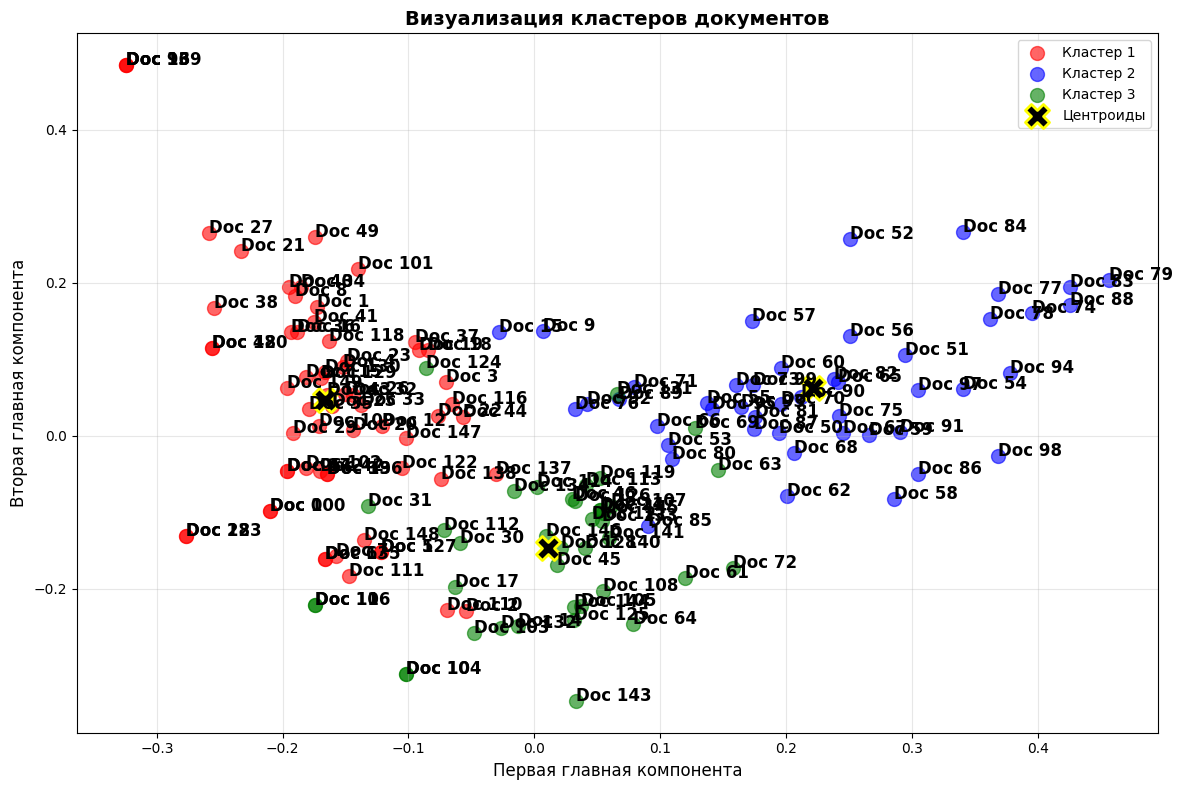

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Уменьшаем размерность для визуализации
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Визуализация кластеров
plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green']

for cluster_id in range(n_clusters):
    cluster_points = X_pca[cluster_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                c=colors[cluster_id], label=f'Кластер {cluster_id + 1}',
                s=100, alpha=0.6)
    
    # Отмечаем документы номерами
    for doc_idx in np.where(cluster_labels == cluster_id)[0]:
        plt.annotate(f'Doc {doc_idx}', 
                    (X_pca[doc_idx, 0], X_pca[doc_idx, 1]),
                    fontsize=12, fontweight='bold')

# Центроиды кластеров
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
            c='black', marker='X', s=300, 
            label='Центроиды', edgecolors='yellow', linewidths=2)

plt.xlabel('Первая главная компонента', fontsize=12)
plt.ylabel('Вторая главная компонента', fontsize=12)
plt.title('Визуализация кластеров документов', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
print("\n" + "="*80)
print("АЛЬТЕРНАТИВНЫЙ ПОДХОД: СРЕДНЕЕ TF-IDF СЛОВ В ДОКУМЕНТАХ КЛАСТЕРА")
print("="*80)

for cluster_id in range(n_clusters):
    print(f"\n{'='*80}")
    print(f"КЛАСТЕР {cluster_id + 1}")
    print('='*80)
    
    # Получаем все документы кластера
    docs_in_cluster = np.where(cluster_labels == cluster_id)[0]
    
    # Вычисляем среднее TF-IDF для слов в документах этого кластера
    cluster_tfidf = X_tfidf[docs_in_cluster].toarray()
    mean_tfidf = cluster_tfidf.mean(axis=0)
    
    # Сортируем по убыванию
    top_indices = mean_tfidf.argsort()[::-1][:15]
    
    for idx, feature_idx in enumerate(top_indices):
        word = feature_names[feature_idx]
        weight = mean_tfidf[feature_idx]
        print(f"{idx + 1:2d}. '{word}' (средний TF-IDF: {weight:.4f})")


АЛЬТЕРНАТИВНЫЙ ПОДХОД: СРЕДНЕЕ TF-IDF СЛОВ В ДОКУМЕНТАХ КЛАСТЕРА

КЛАСТЕР 1
 1. 'требование' (средний TF-IDF: 0.0927)
 2. 'разработка' (средний TF-IDF: 0.0827)
 3. 'команда' (средний TF-IDF: 0.0781)
 4. 'система' (средний TF-IDF: 0.0664)
 5. 'технический' (средний TF-IDF: 0.0647)
 6. 'документация' (средний TF-IDF: 0.0605)
 7. 'процесс' (средний TF-IDF: 0.0584)
 8. 'системный' (средний TF-IDF: 0.0577)
 9. 'анализ' (средний TF-IDF: 0.0547)
10. 'продукт' (средний TF-IDF: 0.0543)
11. 'проект' (средний TF-IDF: 0.0520)
12. 'компания' (средний TF-IDF: 0.0504)
13. 'заказчик' (средний TF-IDF: 0.0486)
14. 'бизнеспроцесс' (средний TF-IDF: 0.0460)
15. 'подготовка' (средний TF-IDF: 0.0443)

КЛАСТЕР 2
 1. 'модель' (средний TF-IDF: 0.1408)
 2. 'данные' (средний TF-IDF: 0.0774)
 3. 'llm' (средний TF-IDF: 0.0687)
 4. 'обучение' (средний TF-IDF: 0.0620)
 5. 'ml' (средний TF-IDF: 0.0569)
 6. 'разработка' (средний TF-IDF: 0.0554)
 7. 'python' (средний TF-IDF: 0.0515)
 8. 'команда' (средний TF-IDF: 0.050


AGGLOMERATIVE (ИЕРАРХИЧЕСКАЯ) КЛАСТЕРИЗАЦИЯ
Количество кластеров: 3

Распределение документов:
Кластер 0: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(43), np.int64(44), np.int64(45), np.int64(47), np.int64(48), np.int64(49), np.int64(61), np.int64(64), np.int64(76), np.int64(80), np.int64(85), np.int64(92), np.int64(93), np.int64(96), np.int64(100), np.int64(101), np.int64(102), np.int64(103), np.int64(104), np.int64(105), np.int64(106), np.int64(108), np.int64(109), np.int64(11

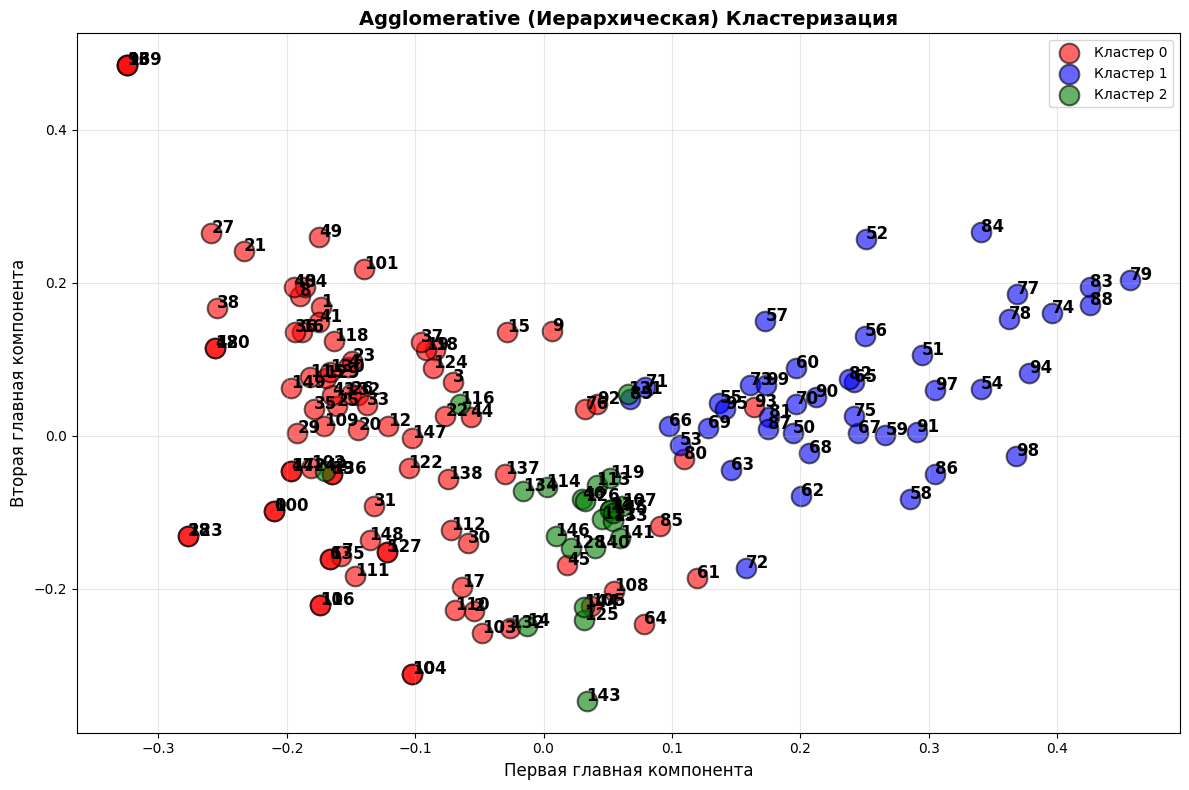

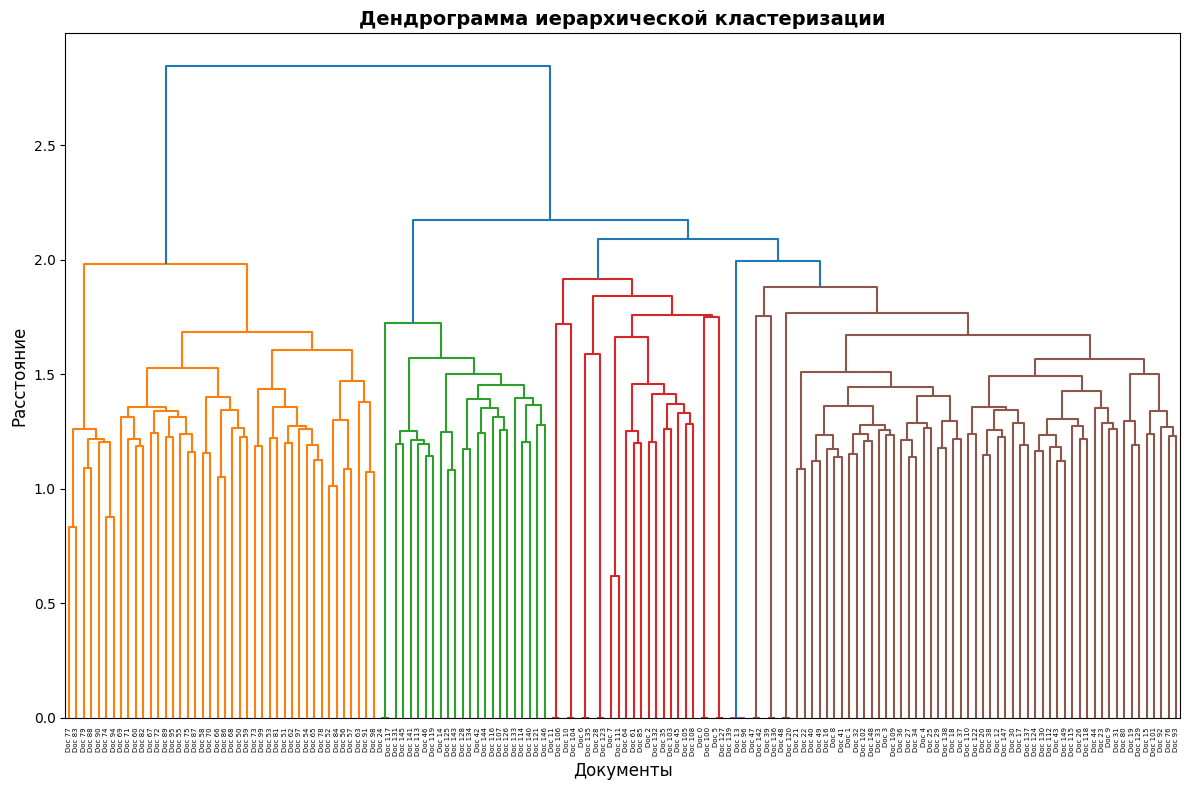

NameError: name 'dbscan_labels' is not defined

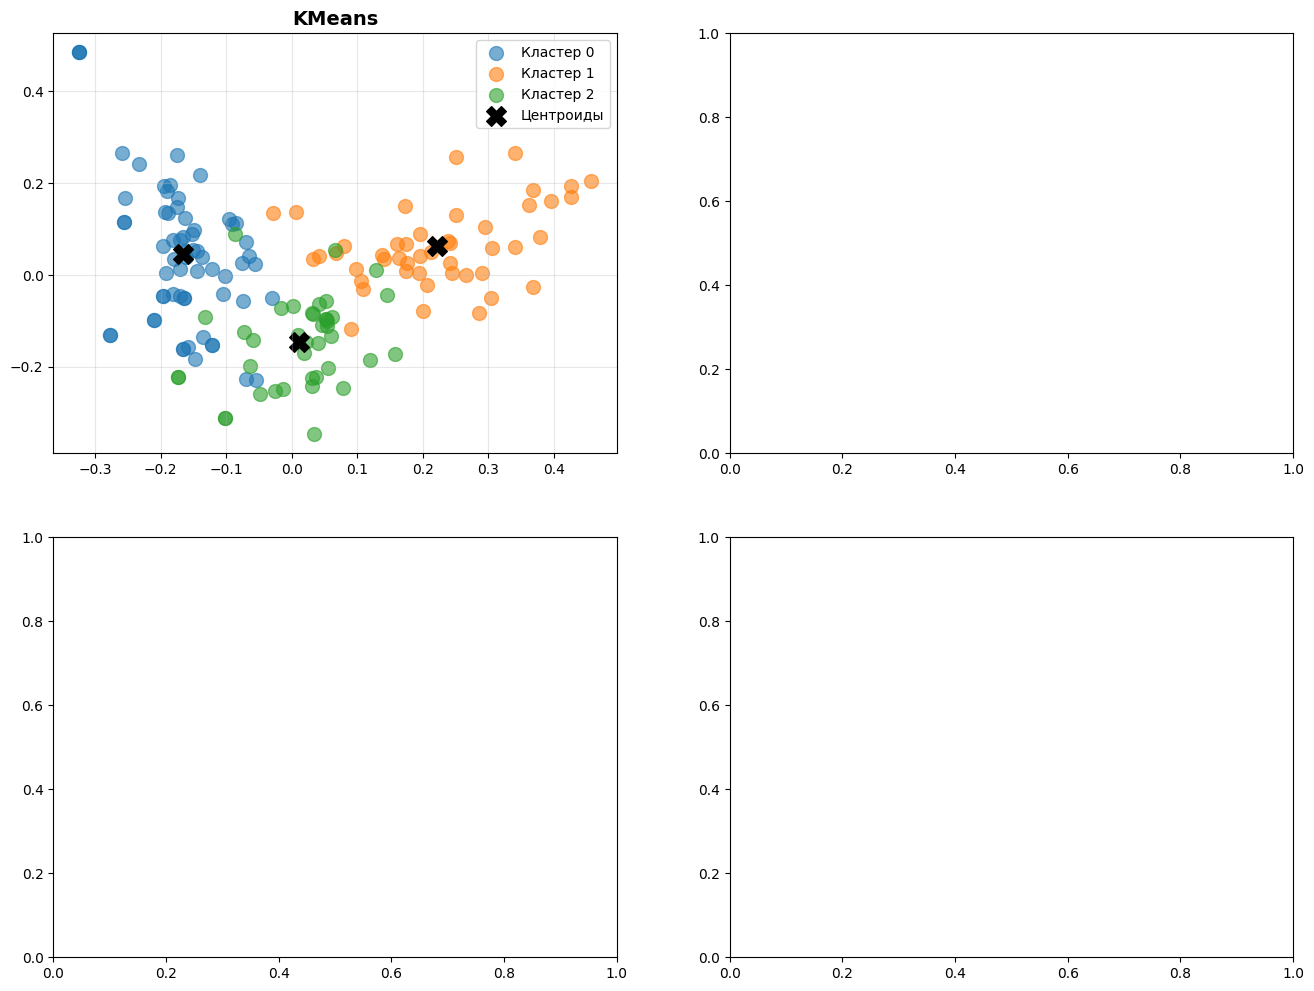

In [15]:
# ============================================================================
# AGGLOMERATIVE CLUSTERING - ЕЩЕ ОДИН МОЩНЫЙ АЛГОРИТМ
# ============================================================================

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

print("\n" + "="*80)
print("AGGLOMERATIVE (ИЕРАРХИЧЕСКАЯ) КЛАСТЕРИЗАЦИЯ")
print("="*80)

# Обучаем иерархическую кластеризацию
agg_clustering = AgglomerativeClustering(n_clusters=3, linkage='ward')
agg_labels = agg_clustering.fit_predict(X_tfidf.toarray())

print(f"Количество кластеров: 3")
print(f"\nРаспределение документов:")

for cluster_id in set(agg_labels):
    docs = list(np.where(agg_labels == cluster_id)[0])
    print(f"Кластер {cluster_id}: {docs}")

# Визуализация Agglomerative
plt.figure(figsize=(12, 8))
colors_agg = ['red', 'blue', 'green']

for cluster_id in set(agg_labels):
    cluster_mask = (agg_labels == cluster_id)
    plt.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1],
                c=colors_agg[cluster_id], marker='o', s=200, alpha=0.6, 
                label=f'Кластер {cluster_id}', edgecolors='black', linewidths=1.5)
    
    for doc_idx in np.where(cluster_mask)[0]:
        plt.annotate(f'{doc_idx}', 
                    (X_pca[doc_idx, 0], X_pca[doc_idx, 1]),
                    fontsize=12, fontweight='bold')

plt.xlabel('Первая главная компонента', fontsize=12)
plt.ylabel('Вторая главная компонента', fontsize=12)
plt.title('Agglomerative (Иерархическая) Кластеризация', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Дендрограмма
plt.figure(figsize=(12, 8))
linkage_matrix = linkage(X_tfidf.toarray(), method='ward')
dendrogram(linkage_matrix, labels=[f'Doc {i}' for i in range(X_tfidf.shape[0])])
plt.xlabel('Документы', fontsize=12)
plt.ylabel('Расстояние', fontsize=12)
plt.title('Дендрограмма иерархической кластеризации', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================================
# СРАВНЕНИЕ ВСЕХ АЛГОРИТМОВ
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# KMeans
ax = axes[0, 0]
for cluster_id in set(cluster_labels):
    cluster_mask = (cluster_labels == cluster_id)
    ax.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1],
               s=100, alpha=0.6, label=f'Кластер {cluster_id}')
centroids_pca = pca.transform(kmeans.cluster_centers_)
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
           c='black', marker='X', s=200, label='Центроиды')
ax.set_title('KMeans', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# DBSCAN
ax = axes[0, 1]
for cluster_id in set(dbscan_labels):
    cluster_mask = (dbscan_labels == cluster_id)
    if cluster_id == -1:
        ax.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1],
                   c='black', marker='x', s=100, alpha=0.6, label='Шум')
    else:
        ax.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1],
                   s=100, alpha=0.6, label=f'Кластер {cluster_id}')
ax.set_title('DBSCAN', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Agglomerative
ax = axes[1, 0]
for cluster_id in set(agg_labels):
    cluster_mask = (agg_labels == cluster_id)
    ax.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1],
               s=100, alpha=0.6, label=f'Кластер {cluster_id}')
ax.set_title('Agglomerative Clustering', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# HDBSCAN (если установлен)
ax = axes[1, 1]
try:
    for cluster_id in set(hdbscan_labels):
        cluster_mask = (hdbscan_labels == cluster_id)
        if cluster_id == -1:
            ax.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1],
                       c='black', marker='x', s=100, alpha=0.6, label='Шум')
        else:
            ax.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1],
                       s=100, alpha=0.6, label=f'Кластер {cluster_id}')
    ax.set_title('HDBSCAN', fontsize=14, fontweight='bold')
except:
    ax.text(0.5, 0.5, 'HDBSCAN не установлен', 
            ha='center', va='center', transform=ax.transAxes, fontsize=14)
    ax.set_title('HDBSCAN (не доступен)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("СРАВНЕНИЕ АЛГОРИТМОВ КЛАСТЕРИЗАЦИИ")
print("="*80)
print("""
1. KMeans: 
   + Быстрый, простой
   - Нужно указывать количество кластеров
   - Кластеры должны быть сферическими
   
2. DBSCAN:
   + Находит кластеры произвольной формы
   + Определяет выбросы (шум)
   - Сложно подобрать параметры (eps, min_samples)
   - Плохо работает с кластерами разной плотности
   
3. HDBSCAN (САМЫЙ МОЩНЫЙ):
   + Автоматически определяет количество кластеров
   + Работает с кластерами разной плотности
   + Предоставляет вероятности принадлежности
   + Более устойчив к параметрам
   - Медленнее чем KMeans
   
4. Agglomerative (Иерархическая):
   + Можно визуализировать дендрограмму
   + Не требует указания числа кластеров заранее (можно обрезать на любом уровне)
   + Работает хорошо с небольшими данными
   - Высокая вычислительная сложность O(n³)
""")